In [1]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

In [207]:
#df = pd.read_csv('train.csv', index_col=[0])

# Feature Engineering

Mind for data directory

In [2]:
DATA_DIR = 'C:/Users/gybj0/Desktop/data'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import os

train = pd.read_csv(os.path.join(DATA_DIR, 'optiver_volatility', 'train.csv'))
stock_ids = set(train['stock_id'])

def load_stock_data(stock_id: int, directory: str) -> pd.DataFrame:
    return pd.read_parquet(os.path.join(DATA_DIR, 'optiver_volatility', directory, f'stock_id={stock_id}'))

def load_book(stock_id: int, type:  str) -> pd.DataFrame:
    return load_stock_data(stock_id, f'book_{type}.parquet')

def load_trade(stock_id: int, type: str) -> pd.DataFrame:
    return load_stock_data(stock_id, f'trade_{type}.parquet')

def calc_wap1(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap2(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def realized_volatility(series: np.ndarray) -> pd.Series:
    return np.sqrt(np.sum(series**2))

def log_return(series: np.ndarray) -> pd.Series:
    return np.log(series).diff()

def log_return_df2(series: np.ndarray) -> pd.Series:
    return np.log(series).diff(2)

def rename(addon: str, columns) -> list:
    ret = []
    for col in columns:
        if col[0] in ['time_id','stock_id']:
            ret.append(col[0])
        else:
            ret.append('_'.join([addon]+list(col)))
    return ret

def make_book_feature(stock_id: int, type: str) -> pd.DataFrame:
    book = load_book(stock_id, type)

    book['wap1'] = calc_wap1(book)
    book['wap2'] = calc_wap2(book)
    book['log_return1'] = book.groupby(['time_id'])['wap1'].apply(log_return)
    book['log_return2'] = book.groupby(['time_id'])['wap2'].apply(log_return)
    book['log_return_ask1'] = book.groupby(['time_id'])['ask_price1'].apply(log_return)
    book['log_return_ask2'] = book.groupby(['time_id'])['ask_price2'].apply(log_return)
    book['log_return_bid1'] = book.groupby(['time_id'])['bid_price1'].apply(log_return)
    book['log_return_bid2'] = book.groupby(['time_id'])['bid_price2'].apply(log_return)

    book['wap_balance'] = abs(book['wap1'] - book['wap2'])
    book['price_spread'] = (book['ask_price1'] - book['bid_price1']) / ((book['ask_price1'] + book['bid_price1']) / 2)
    book['bid_spread'] = book['bid_price1'] - book['bid_price2']
    book['ask_spread'] = book['ask_price1'] - book['ask_price2']
    book['total_volume'] = (book['ask_size1'] + book['ask_size2']) + (book['bid_size1'] + book['bid_size2'])
    book['volume_imbalance'] = abs((book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] + book['bid_size2']))

    features = {
        'seconds_in_bucket': ['count'],
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std]
    }
    
    book = book.fillna(method = 'ffill').dropna()
    agg = book.groupby('time_id').agg(features).reset_index(drop=False)
    agg.columns = rename('book', agg.columns)
    agg['stock_id'] = stock_id   

    for time in [450, 300, 150]:
        d = book[book['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = rename(f'{time}', d.columns)
        agg = pd.merge(agg, d, on = 'time_id', how = 'left')
    return agg

def make_trade_feature(stock_id: int, type: str) -> pd.DataFrame:
    trade = load_trade(stock_id, type)
    trade['log_return'] = trade.groupby('time_id')['price'].apply(log_return)

    features = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':['count'],
        'size':[np.sum],
        'order_count':[np.mean],
    }

    trade = trade.fillna(method = 'ffill').dropna()
    agg = trade.groupby('time_id').agg(features).reset_index()
    agg.columns = rename('trade', agg.columns)
    agg['stock_id'] = stock_id

    for time in [450, 300, 150]:
        d = trade[trade['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = rename(f'{time}', d.columns)
        agg = pd.merge(agg, d, on = 'time_id', how = 'left')
    return agg

def make_features(stock_ids: list[int], type: str) -> pd.DataFrame:
    from joblib import Parallel, delayed
    book = Parallel(n_jobs = -1)(delayed(make_book_feature)(i, type) for i in stock_ids)
    books = pd.concat(book)
    trade = Parallel(n_jobs = -1)(delayed(make_trade_feature)(i, type) for i in stock_ids)
    trades = pd.concat(trade)
    df = pd.merge(books, trades, on = ['time_id','stock_id'], suffixes = ['_book','_trade'])
    return df

In [22]:
try:
    df = pd.read_csv('feature_v2.csv', index_col = [0])
except:
    df = make_features(stock_ids, 'train')
    #df.to_csv('feature_v2.csv')

In [4]:
df.shape

(427233, 214)

In [5]:
test_df = make_features([0], 'test')

In [6]:
test_df.shape

(1, 214)

# Train Data, Time id

In [24]:
time_ids = df.time_id.factorize()[1]
time_indexes = df.time_id.factorize()[0]
time_len = len(time_ids)
html_time = 0.1
train_time = time_ids[int((1 - html_time) * time_len)]

Rating critiria used in competition: Root Mean Square Percentage Error

$$ \frac{1}{n}\sum{\sqrt{\frac{y_{true} - y_{pred}}{y_{true}}}} $$

In [7]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

X_train = df.copy()
X_train['target'] = train.target

# Train NN

In [8]:
from sklearn.neighbors import NearestNeighbors

class Neighbors:
    def __init__(self, name: str, n_neighbor: int, pivot: pd.DataFrame):
        '''
        name: name of the neighbor
        n_neighbor: max number of neighbors can be selected
        pivot: DataFrame that contains timeid, stockid and features value as value
        X_train: DataFrame that contains all the feature
        '''
        self.name = name
        self.n_neighbor = n_neighbor
        self.pivot = pivot
        nn = NearestNeighbors(n_neighbors=n_neighbor)
        nn.fit(pivot)
        self.nn_ind = nn.kneighbors(pivot, n_neighbors=n_neighbor, return_distance=False)
        self.time = X_train.time_id.factorize()[0]
        self.stock = X_train.stock_id.factorize()[0]       

    def make_nn_features(self, n: int, method=np.mean):
        '''
        Construct neighbor's feature for a given colume, method, and number of neighbors
        Must run make_nn_time or make_nn_stock before this.
        n: number of neighbors to select and calculate
        col: name of neighbor's feature
        method: function to calculate properties of neighbors, default to calculate mean
        '''
        assert(self.features is not None)

        self.agg = pd.DataFrame(
            method(self.features.iloc[:, 1:n], axis = 1),
            columns = [f'{self.name}_{str(n)}_{self.col}_{method.__name__}']
        )

class TimeNeighbors(Neighbors):
    def make_nn_time(self, pivot: pd.DataFrame, feature_col: str):
        '''
        Find values in each neighbor for a specific feature
        pivot: DataFrame that contains timeid, stockid and features value as value
        feature_col: name of the feature that we want to extract from neighbors
        '''  
        pivot = pivot.pivot('time_id', 'stock_id', feature_col)
        pivot = pivot.fillna(pivot.mean())
        self.features = pd.DataFrame(pivot.values[self.nn_ind[self.time, 1:self.n_neighbor], self.stock[:, None]])
        self.col = feature_col

class StockNeighbors(Neighbors):        
    def make_nn_stock(self, pivot: pd.DataFrame, feature_col: str):
        '''
        Find values in each neighbor for a specific feature
        pivot: DataFrame that contains timeid, stockid and features value as value
        feature_col: name of the feature that we want to extract from neighbors
        '''  
        pivot = pivot.pivot('time_id', 'stock_id', feature_col)
        pivot = pivot.fillna(pivot.mean())
        self.features = pd.DataFrame(pivot.T.values[self.nn_ind[self.stock, 1:self.n_neighbor], self.time[:, None]])
        self.col = feature_col


In [9]:
from sklearn.preprocessing import minmax_scale
time_neighbor = []
stock_neighbor = []
pv = X_train.copy()
#make time neighbor based on volatility, trading volume, and return
pivot = pv.pivot('time_id','stock_id','book_log_return1_realized_volatility')
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))
time_neighbor.append(TimeNeighbors('time_vol', 40, pivot))

pivot = pv.pivot('time_id','stock_id','trade_size_sum')
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))
time_neighbor.append(TimeNeighbors('time_trade_size_sum', 40, pivot))

pivot = pv.pivot('time_id','stock_id','book_log_return1_mean')
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))
time_neighbor.append(TimeNeighbors('time_log_return1_mean', 40, pivot))

pivot = pv.pivot('time_id','stock_id','trade_order_count_mean')
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))
time_neighbor.append(TimeNeighbors('time_order_count_mean', 40, pivot))

#make stock neighbor based on volatility and return
pivot = pv.pivot('time_id','stock_id','book_log_return1_realized_volatility')
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))
stock_neighbor.append(StockNeighbors('stock_vol', 80, minmax_scale(pivot.T)))

pivot = pv.pivot('time_id','stock_id','book_log_return1_mean')
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))
stock_neighbor.append(StockNeighbors('stock_log_return1_mean', 80, minmax_scale(pivot.T)))


In [10]:
def cal_rank_correaltion(neighbors):
    rank = pd.DataFrame()
    for n in neighbors:
        print(n.name)
        rank[n.name] = n.nn_ind.flatten()

    sns.heatmap(rank.corr(), annot = True)

time_vol
time_trade_size_sum
time_log_return1_mean
time_order_count_mean


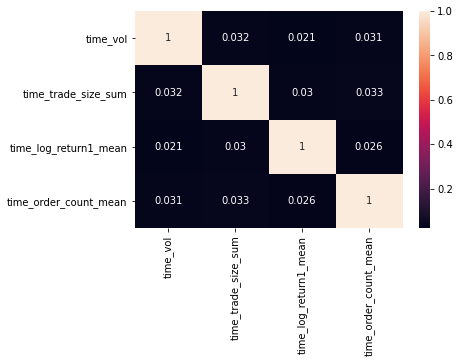

In [11]:
cal_rank_correaltion(time_neighbor)

stock_vol
stock_log_return1_mean


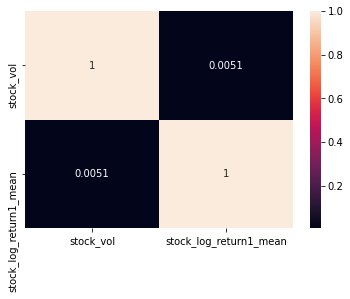

In [12]:
cal_rank_correaltion(stock_neighbor)

Integrate NN features

In [13]:
def make_nn_features(df: pd.DataFrame) -> pd.DataFrame:
    #aggregate features according to different features, functions, and number of neighbors
    df2 = df.copy()

    methods_stocks = {
        'book_log_return1_realized_volatility': [np.mean, np.min, np.max, np.std],
        'trade_order_count_mean': [np.mean],
        'book_log_return1_mean': [np.mean],
        'trade_size_sum': [np.mean],
        'book_seconds_in_bucket_count': [np.mean],
    }
    
    methods_time = {
        'book_log_return1_realized_volatility': [np.mean, np.min, np.max, np.std],
        'trade_order_count_mean': [np.mean],
        'book_log_return1_mean': [np.mean],
        'trade_size_sum': [np.mean],
        'book_seconds_in_bucket_count': [np.mean],
    }

    time_n = [2, 3, 5, 10, 20, 40]
    stock_n = [5, 10, 20, 40, 60, 80]
    cols = []

    for col in methods_time.keys():

        for nn in time_neighbor:
            nn.make_nn_time(df2, col)

        for method in methods_time[col]:
            for n in time_n:
                nn.make_nn_features(n, method)
                feat = nn.agg
                cols.append(feat)

    for col in methods_stocks.keys():

        for nn in stock_neighbor:
            nn.make_nn_stock(df2, col)

        for method in methods_stocks[col]:
            for n in stock_n:
                nn.make_nn_features(n, method)
                feat = nn.agg
                cols.append(feat)    
    
    ndf = pd.concat(cols, axis = 1)
    df2 = pd.concat([df2, ndf], axis = 1)
    return df2

In [28]:
df_nn = make_nn_features(X_train)

In [29]:
df_nn.shape

(427233, 311)

In [36]:
df_nn = df_nn.fillna(df_nn.mean())

In [40]:
import gc
gc.collect()

del df
del pv
del time_indexes
del train
del X_train

In [26]:
#df_nn.to_csv('nn_features.csv')

# CV and test split

In [31]:
fold_bolder = [3830 - 383 * 5, 3830 - 383 * 4,3830 - 383 * 3,3830 - 383 * 2,3830 - 383 * 1,]
fold = []
df_nn = df_nn.sort_values(by = ['time_id', 'stock_id'])
df_nn = df_nn.reset_index()
for i in fold_bolder:
    idx_valid = time_ids[i: i + 383]
    ind_train = np.where(df_nn.time_id<idx_valid[0])[0]
    ind_valid = np.where((df_nn.time_id>=idx_valid[0])&(df_nn.time_id<idx_valid[-1]))[0]
    fold.append((ind_train, ind_valid))

In [33]:
fold

[(array([     0,      1,      2, ..., 215073, 215074, 215075], dtype=int64),
  array([215076, 215077, 215078, ..., 257700, 257701, 257702], dtype=int64)),
 (array([     0,      1,      2, ..., 257812, 257813, 257814], dtype=int64),
  array([257815, 257816, 257817, ..., 300853, 300854, 300855], dtype=int64)),
 (array([     0,      1,      2, ..., 300964, 300965, 300966], dtype=int64),
  array([300967, 300968, 300969, ..., 343675, 343676, 343677], dtype=int64)),
 (array([     0,      1,      2, ..., 343787, 343788, 343789], dtype=int64),
  array([343790, 343791, 343792, ..., 387055, 387056, 387057], dtype=int64)),
 (array([     0,      1,      2, ..., 387167, 387168, 387169], dtype=int64),
  array([387170, 387171, 387172, ..., 417637, 417638, 417639], dtype=int64))]

In [34]:
del ind_train
del ind_valid

# Baseline Model: Linear Regression

In [37]:
df_train = df_nn[df_nn.index <= fold[-1][0][-1]]
df_test = df_nn[df_nn.index > fold[-1][0][-1]]

from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = df_train[[col for col in df_train.columns if col not in ['target','time_id','stock_id','level_0','index']]]
y = df_train['target']
X_test = df_test[[col for col in df_test.columns if col not in ['target','time_id','stock_id','level_0','index']]]
y_test = df_test['target']

model.fit(X, y)
y_pred = model.predict(X_test)
print(rmspe(y_test, y_pred))

0.9010678952599911


# LGBM Training

In [38]:
X = df_train[[col for col in df_train.columns if col not in ['target','time_id','stock_id','level_0','index']]]
y = df_train['target']

In [39]:
import lightgbm as lgb
ds = lgb.Dataset(X, y, weight = 1/np.power(y, 2))

In [41]:
params = {
    'objective': 'regression',
    'verbose': 0,
    'metric': '',
    'reg_alpha': 5,
    'reg_lambda': 5,
    'min_data_in_leaf': 1000,
    'max_depth': -1,
    'num_leaves': 128,
    'colsample_bytree': 0.3,
    'learning_rate': 0.3
}

def feval_rmspe(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

ret = lgb.cv(params, ds, num_boost_round = 8000, folds = fold[:-1],
            feval = feval_rmspe, stratified = False,
            return_cvbooster = True, verbose_eval = 20,
            early_stopping_rounds = int(120*0.1/0.3))

best_iter = len(ret['RMSPE-mean'])

c:\Users\gybj0\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.436872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.755578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.854783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.699264 seconds.
You can set `force_col_wise=true` to remove the overhead.


c:\Users\gybj0\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	cv_agg's l2: 1.12242e-06 + 4.48694e-08	cv_agg's RMSPE: 0.489118 + 0.00959791
[40]	cv_agg's l2: 1.13329e-06 + 4.84244e-08	cv_agg's RMSPE: 0.491465 + 0.0102641


# fold0 RMSPE: 0.4960161885334517
# fold1 RMSPE: 0.4986320131465179
# fold2 RMSPE: 0.4816397290018398
# fold3 RMSPE: 0.47767268524955786


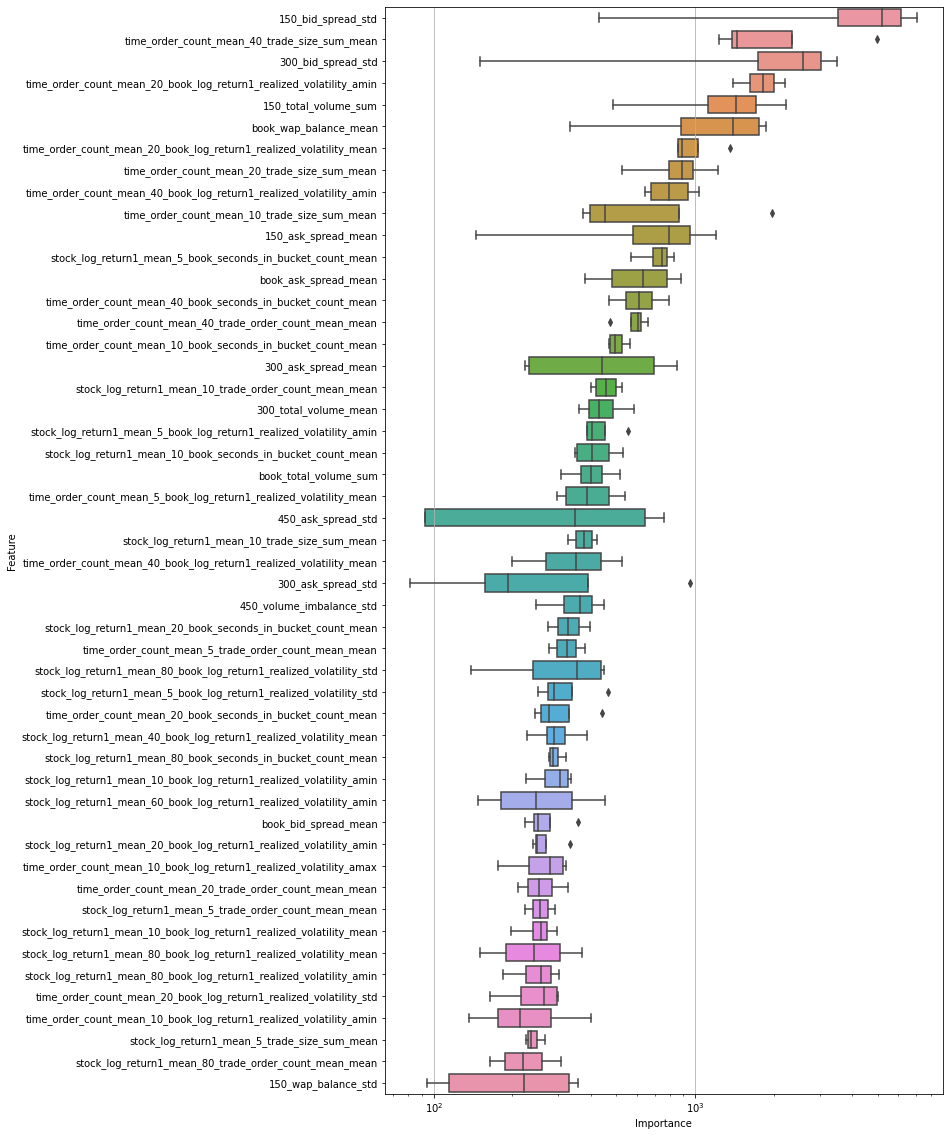

In [42]:
def plot_importance(cvbooster, figsize=(10, 10)):
    raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = cvbooster.boosters[0].feature_name()
    importance_df = pd.DataFrame(data=raw_importances,
                                 columns=feature_name)
    # order by average importance across folds
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    # plot top-n
    PLOT_TOP_N = 50
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

for i in range(len(fold) - 1):
    y_pred = ret['cvbooster'].boosters[i].predict(X.iloc[fold[i][1]], num_iteration=best_iter)
    y_true = y.iloc[fold[i][1]]
    print(f"# fold{i} RMSPE: {rmspe(y_true, y_pred)}")
    
    if i == len(fold) - 1:
        np.save('pred_gbdt.npy', y_pred)

plot_importance(ret['cvbooster'], figsize=(10, 20))
    